In [1]:
library(tidyverse)
library(tidymodels)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
project_dir <- '/kaggle/input/nfl-big-data-bowl-2024'

df_games <- read_csv(paste0(project_dir, '/games.csv'))
df_players <- read_csv(paste0(project_dir, '/players.csv'))
df_plays <- read_csv(paste0(project_dir, '/plays.csv'))
df_tackles <- read_csv(paste0(project_dir, '/tackles.csv'))


df_tracking <- read_csv(paste0(project_dir, '/tracking_week_1.csv'))

Rows: 136 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): gameDate, homeTeamAbbr, visitorTeamAbbr
dbl  (5): gameId, season, week, homeFinalScore, visitorFinalScore
time (1): gameTimeEastern

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1683 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): height, birthDate, collegeName, position, displayName
dbl (2): nflId, weight

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 12486 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): ballCarrierDisplayName, playDescription, possessionTeam, defensiv...
dbl  (24): gameId, playId, 

In [3]:
head(df_tracking)

gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dttm>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2022090800,56,35472,Rodger Saffold,1,2022-09-08 20:24:05,76,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NA
2022090800,56,35472,Rodger Saffold,2,2022-09-08 20:24:05,76,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2022090800,56,35472,Rodger Saffold,3,2022-09-08 20:24:05,76,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NA
2022090800,56,35472,Rodger Saffold,4,2022-09-08 20:24:05,76,BUF,left,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NA
2022090800,56,35472,Rodger Saffold,5,2022-09-08 20:24:05,76,BUF,left,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NA
2022090800,56,35472,Rodger Saffold,6,2022-09-08 20:24:05,76,BUF,left,88.80,26.70,1.15,1.42,0.12,234.48,139.41,pass_outcome_caught


In [4]:
df_tracking2 <- df_tracking %>%
    mutate(
        x = ifelse(playDirection == 'left', 120-x, x),
        y = ifelse(playDirection == 'left', 160/3 - y, y),
        o = ifelse(playDirection == 'left', abs(o - 180), o), 
        dir = ifelse(playDirection == 'left', abs(dir - 180), dir),
        x_end = s*cos((90 - dir)*pi / 180) + x,
        y_end = s*sin((90 - dir)*pi / 180) + y,
    ) %>%
    group_by(gameId, playId) %>%
    mutate(
        x_start = min(ifelse(club == 'football' & frameId == 1, x, NA), na.rm = TRUE)
    ) %>% 
    ungroup() %>%
    mutate(x = x - x_start) %>%
    group_by(gameId, playId, frameId) %>%
    mutate(
        x_ball = min(if_else(club == 'football', x, NA), na.rm = TRUE),
        y_ball = min(if_else(club == 'football', y, NA), na.rm = TRUE),
    ) %>%
    ungroup() %>%
    mutate(
        dist_from_ball = sqrt( ((x - x_ball) ** 2) + ((y - y_ball) ** 2) )
    )

## Checking calcs

* Dist to ball
* standardized x-axis

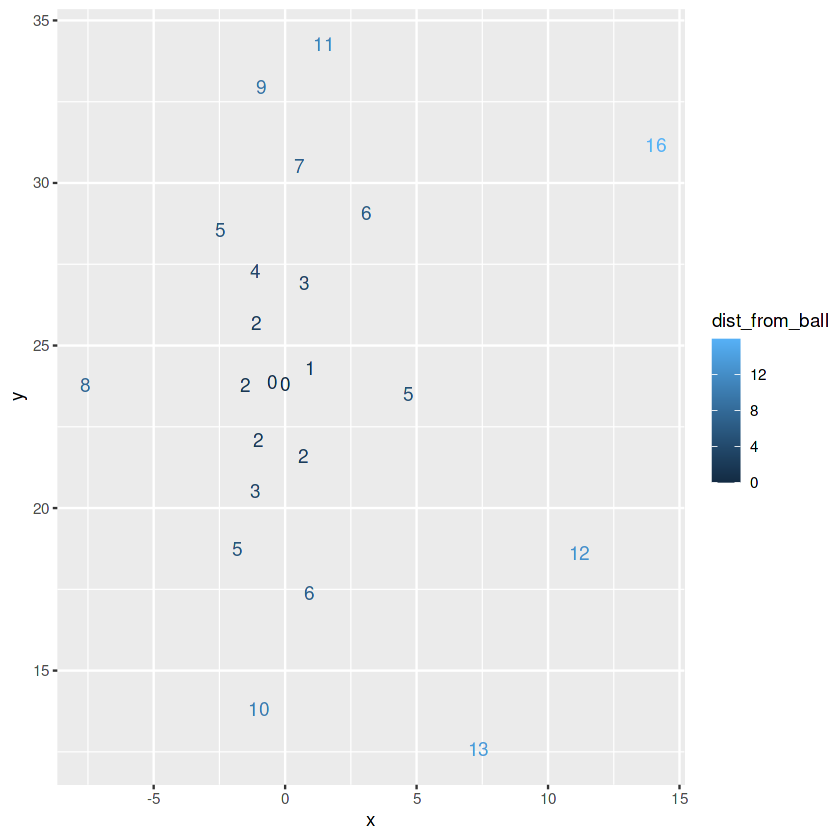

In [5]:
df_tracking2 %>%
    filter(gameId == 2022090800, playId == 101) %>%
    filter(frameId == 1) %>%
    ggplot(aes(x, y, color = dist_from_ball, shape = club)) + 
    #geom_point(aes(alpha = frameId)) +
    geom_text(aes(label = round(dist_from_ball))) 

Joining with `by = join_by(gameId, playId)`


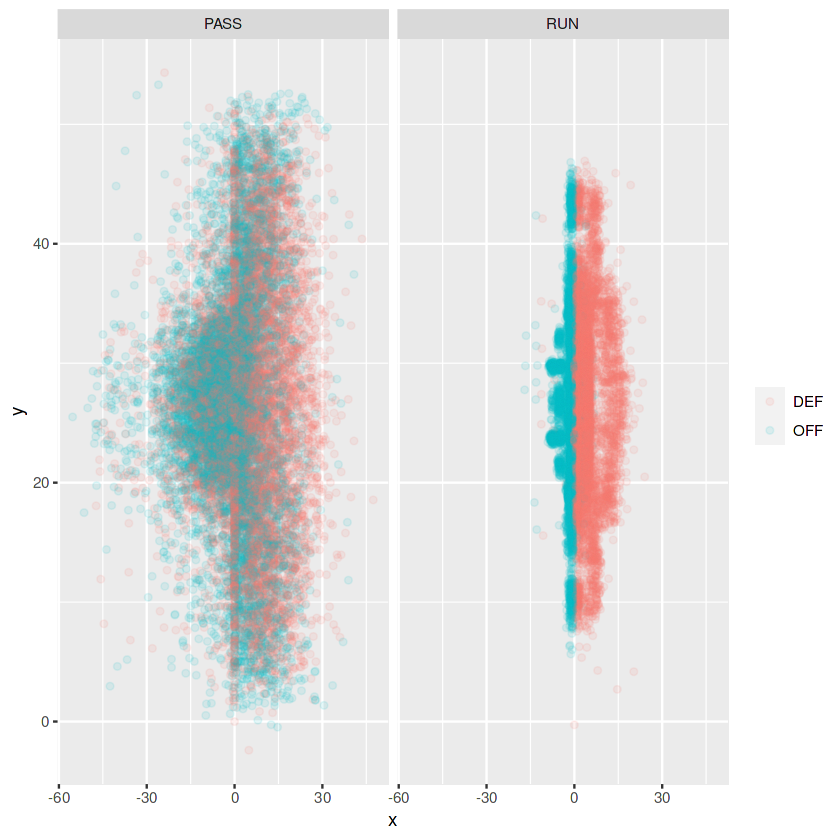

In [6]:
df_tracking2 %>%
    left_join(df_plays) %>%
    filter(frameId == 1) %>%
    ggplot(aes(x, y, color = ifelse(club == possessionTeam, 'OFF', 'DEF'))) +
    geom_point(alpha = 0.1) +
    facet_wrap(~ifelse(is.na(passResult), 'RUN', 'PASS')) +
    labs(color = NULL)

In [7]:
df_players <- df_players %>% 
    mutate(
        position_group = case_when(
            position %in% c('DB', 'CB') ~ 'CB',
            position %in% c('SS', 'FS') ~ 'S',
            position %in% c('G', 'C', 'LS') ~ 'IOL',
            position %in% c('DE', 'OLB') ~ 'EDGE',
            position %in% c('DT', 'NT') ~ 'DT',
            position %in% c('ILB', 'MLB') ~ 'ILB',
            TRUE ~ position
        )
    ) 
    

In [8]:
# How many plays have ball snap, 
# looks to be only running plays which 
df_tracking %>% 
#group_by(gameId) %>%
summarise(
    snaps = n_distinct(ifelse(event == 'autoevent_ballsnap' | event == 'ball_snap', playId, NA)),
    n = n_distinct(playId)
)
    

snaps,n
<int>,<int>
649,1247


## Wide Position Data

A wide dataframe with each position and their distance to the ball

In [9]:
df_tracking2 %>%
    filter(gameId == 2022090800, playId == 56) %>%
    left_join(
        df_players %>%
            select(nflId, position_group)
    ) %>%
    mutate(position_group = ifelse(club == 'football', 'football', position_group)) %>%
    group_by(gameId, playId, frameId, position_group) %>%
    arrange(-y) %>%
    mutate(
        rn = row_number(),
        pos = paste0(position_group, rn),
        pos = ifelse(pos == 'football1', 'football', pos)
    ) %>%
    ungroup() %>%
    pivot_wider(
        id_cols = c(gameId, playId, frameId),
        names_from = pos,
        values_from = dist_from_ball
    )    

Joining with `by = join_by(nflId)`


gameId,playId,frameId,WR1,CB1,WR2,S1,S2,RB1,TE1,⋯,QB1,DT3,IOL3,T2,EDGE1,S3,ILB2,CB2,football,WR3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022090800,56,20,35.12477,27.00522,26.03312,18.09526,9.153125,15.98015,12.528440,⋯,13.131870,8.885322,10.185403,14.493430,13.332157,6.306230,3.043221,2.6617462,0,2.78642940
2022090800,56,21,35.28663,26.75985,26.25492,17.81253,8.946312,15.88952,12.535761,⋯,12.999599,8.774621,10.027586,14.440376,13.248489,6.051943,3.065892,2.6873212,0,2.79084106
2022090800,56,19,34.92413,27.25380,25.78922,18.39234,9.380325,16.05182,12.467438,⋯,13.273403,9.014524,10.348427,14.533768,13.407465,6.556496,3.021059,2.6201132,0,2.77416458
2022090800,56,22,35.18285,26.25014,26.13371,17.36712,8.445052,15.46160,12.246669,⋯,12.634955,8.450052,9.662323,14.192708,12.969413,5.704911,2.764633,2.3724455,0,2.47202275
2022090800,56,18,34.89166,27.74583,25.75846,18.83399,9.904546,16.37088,12.585761,⋯,13.603438,9.333861,10.708368,14.722663,13.635293,6.890178,3.271240,2.8246070,0,3.03461694
2022090800,56,17,34.64753,28.01169,25.45594,19.15919,10.202594,16.38225,12.453249,⋯,13.727617,9.451907,10.877107,14.743848,13.688527,7.166484,3.260002,2.7195790,0,3.01763361
2022090800,56,16,34.59466,28.52718,25.41070,19.61275,10.820075,16.70708,12.493582,⋯,14.095495,9.851743,13.197654,14.973746,13.967694,7.467756,3.560127,2.9020349,0,3.31344389
2022090800,56,15,34.30856,28.79488,25.04860,19.94563,11.160041,16.69618,12.268893,⋯,14.179851,9.996848,13.387881,14.962970,14.011483,7.745898,3.561138,2.7300189,0,3.27391213
2022090800,56,14,34.26848,29.35168,24.98063,20.41458,11.882629,17.03955,12.262402,⋯,14.572317,10.475517,13.870127,15.240014,14.323531,8.023025,3.920458,2.8793391,0,3.59343692


In [10]:
read_nfl_data <- function(x) {
    message(x)
    read_csv(x) %>%
    mutate(
        x = ifelse(playDirection == 'left', 120-x, x),
        y = ifelse(playDirection == 'left', 160/3 - y, y),
        o = ifelse(playDirection == 'left', abs(o - 180), o), 
        dir = ifelse(playDirection == 'left', abs(dir - 180), dir),
        x_end = s*cos((90 - dir)*pi / 180) + x,
        y_end = s*sin((90 - dir)*pi / 180) + y,
    ) %>%
    group_by(gameId, playId) %>%
    mutate(
        x_start = min(ifelse(club == 'football' & frameId == 1, x, NA), na.rm = TRUE)
    ) %>% 
    ungroup() %>%
    mutate(x = x - x_start) %>%
    group_by(gameId, playId, frameId) %>%
    mutate(
        x_ball = min(if_else(club == 'football', x, NA), na.rm = TRUE),
        y_ball = min(if_else(club == 'football', y, NA), na.rm = TRUE),
    ) %>%
    ungroup() %>%
    mutate(
        dist_from_ball = sqrt( ((x - x_ball) ** 2) + ((y - y_ball) ** 2) )
    )
}


In [11]:
df_all_tracking <- list.files(path = '/kaggle/input/nfl-big-data-bowl-2024', pattern = 'tracking*') %>%
    map_dfr(~read_nfl_data(paste0(project_dir, '/', .))) %>%
    left_join(df_plays, by = c('gameId', 'playId')) %>%
    left_join(df_tackles, by = c('gameId', 'playId', 'nflId')) %>%
    left_join(
            df_players %>%
                select(nflId, position_group)
        ) %>%
    mutate(
        tackle = replace_na(tackle, 0),
        assist = replace_na(assist, 0),
        tackle = ifelse(tackle > 0 | assist > 0, 1, 0),
        tackle = as.factor(tackle)
    ) 


/kaggle/input/nfl-big-data-bowl-2024/tracking_week_1.csv

Rows: 1407439 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): displayName, club, playDirection, event
dbl  (12): gameId, playId, nflId, frameId, jerseyNumber, x, y, s, a, dis, o,...
dttm  (1): time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_2.csv

Rows: 1371600 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): displayName, club, playDirection, event
dbl  (12): gameId, playId, nflId, frameId, jerseyNumber, x, y, s, a, dis, o,...
dttm  (1): time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
/kaggle/input/nfl-big-data-bowl-2024

In [12]:
saveRDS(df_all_tracking, '/kaggle/working/df_all_tracking.rds')